In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla
from target import GMM_target, GMM_target2
from args import get_args

In [2]:
args = get_args()

In [3]:
target = GMM_target2(args)

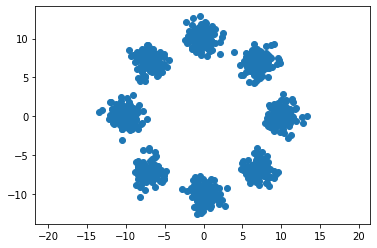

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 1000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

Now we are running warmup!


  1%|          | 8/1000 [00:00<00:13, 71.53it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:13<00:00, 71.74it/s]


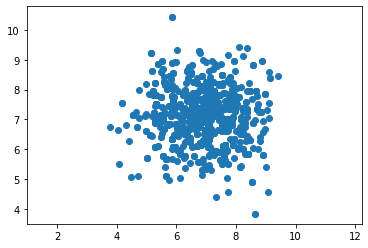

In [9]:
chain_num = 4
plt.scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu())
plt.axis('equal');

#### Ours HMC

In [10]:
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
params = transitions.parameters()

optimizer = torch.optim.Adam(params=params, lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=100, factor=0.9)

##### Training

  0%|          | 0/5000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.065 and for +1: 0.935
Step size for 0-th transition is 1.0
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.755 and for +1: 0.245
Step size for 1-th transition is 1.0
Alpha (ref) for 1-th transition is 0.5
On batch number 0 and on k = 3 we have for 0: 0.36 and for +1: 0.64
Step size for 2-th transition is 1.0
Alpha (ref) for 2-th transition is 0.5
On batch number 0 and on k = 4 we have for 0: 0.41 and for +1: 0.59
Step size for 3-th transition is 1.0
Alpha (ref) for 3-th transition is 0.5
On batch number 0 and on k = 5 we have for 0: 0.445 and for +1: 0.555
Step size for 4-th transition is 1.0
Alpha (ref) for 4-th transition is 0.5


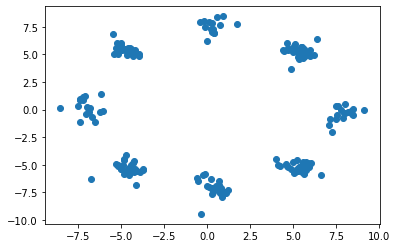

  0%|          | 1/5000 [00:00<16:51,  4.94it/s]

Current lr:  0.1
On batch number 0 ELBO is -13.555489540100098
On batch number 0 Best ELBO is -inf


  2%|▏         | 100/5000 [00:10<08:38,  9.45it/s]

On batch number 100 and on k = 1 we have for 0: 0.0 and for +1: 1.0
Step size for 0-th transition is 1.366655945777893
Alpha (ref) for 0-th transition is 0.6901626586914062
On batch number 100 and on k = 2 we have for 0: 0.47 and for +1: 0.53
Step size for 1-th transition is 0.098526231944561
Alpha (ref) for 1-th transition is 0.8580954670906067
On batch number 100 and on k = 3 we have for 0: 0.505 and for +1: 0.495
Step size for 2-th transition is 1.501810908317566
Alpha (ref) for 2-th transition is 0.19754768908023834
On batch number 100 and on k = 4 we have for 0: 0.45 and for +1: 0.55
Step size for 3-th transition is 0.13830120861530304
Alpha (ref) for 3-th transition is 0.5283372402191162
On batch number 100 and on k = 5 we have for 0: 0.54 and for +1: 0.46
Step size for 4-th transition is 0.12440157681703568
Alpha (ref) for 4-th transition is 0.5280680060386658


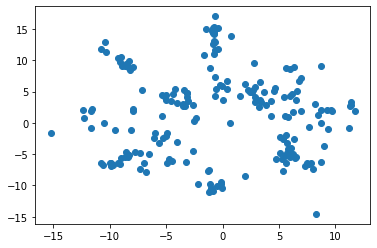

  2%|▏         | 101/5000 [00:10<10:37,  7.69it/s]

Current lr:  0.1
On batch number 100 ELBO is -16.090599060058594
On batch number 100 Best ELBO is -8.362927436828613


  4%|▍         | 200/5000 [00:21<08:25,  9.49it/s]

On batch number 200 and on k = 1 we have for 0: 0.01 and for +1: 0.99
Step size for 0-th transition is 0.9168904423713684
Alpha (ref) for 0-th transition is 0.5574475526809692
On batch number 200 and on k = 2 we have for 0: 0.485 and for +1: 0.515
Step size for 1-th transition is 0.09188644587993622
Alpha (ref) for 1-th transition is 0.8666349649429321
On batch number 200 and on k = 3 we have for 0: 0.62 and for +1: 0.38
Step size for 2-th transition is 1.5349522829055786
Alpha (ref) for 2-th transition is 0.16779939830303192
On batch number 200 and on k = 4 we have for 0: 0.485 and for +1: 0.515
Step size for 3-th transition is 0.13078922033309937
Alpha (ref) for 3-th transition is 0.605675995349884
On batch number 200 and on k = 5 we have for 0: 0.515 and for +1: 0.485
Step size for 4-th transition is 0.10759086906909943
Alpha (ref) for 4-th transition is 0.7016739249229431


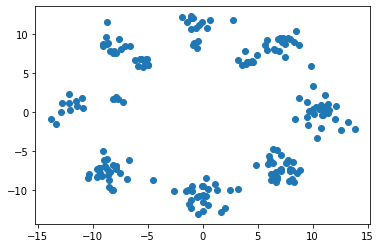

  4%|▍         | 201/5000 [00:21<10:12,  7.83it/s]

Current lr:  0.09000000000000001
On batch number 200 ELBO is -10.935935974121094
On batch number 200 Best ELBO is -8.362927436828613


  6%|▌         | 300/5000 [00:31<08:14,  9.50it/s]

On batch number 300 and on k = 1 we have for 0: 0.09 and for +1: 0.91
Step size for 0-th transition is 0.9952535033226013
Alpha (ref) for 0-th transition is 0.46257510781288147
On batch number 300 and on k = 2 we have for 0: 0.53 and for +1: 0.47
Step size for 1-th transition is 0.09593908488750458
Alpha (ref) for 1-th transition is 0.8616470694541931
On batch number 300 and on k = 3 we have for 0: 0.59 and for +1: 0.41
Step size for 2-th transition is 1.5778565406799316
Alpha (ref) for 2-th transition is 0.12684540450572968
On batch number 300 and on k = 4 we have for 0: 0.505 and for +1: 0.495
Step size for 3-th transition is 0.13836570084095
Alpha (ref) for 3-th transition is 0.6620716452598572
On batch number 300 and on k = 5 we have for 0: 0.525 and for +1: 0.475
Step size for 4-th transition is 0.09771490097045898
Alpha (ref) for 4-th transition is 0.7670320868492126


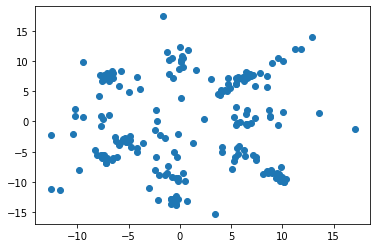

  6%|▌         | 301/5000 [00:32<10:35,  7.39it/s]

Current lr:  0.08100000000000002
On batch number 300 ELBO is -15.241244316101074
On batch number 300 Best ELBO is -8.362927436828613


  8%|▊         | 400/5000 [00:42<08:15,  9.29it/s]

On batch number 400 and on k = 1 we have for 0: 0.035 and for +1: 0.965
Step size for 0-th transition is 0.9697604179382324
Alpha (ref) for 0-th transition is 0.44950613379478455
On batch number 400 and on k = 2 we have for 0: 0.49 and for +1: 0.51
Step size for 1-th transition is 0.09824161231517792
Alpha (ref) for 1-th transition is 0.8680074214935303
On batch number 400 and on k = 3 we have for 0: 0.65 and for +1: 0.35
Step size for 2-th transition is 1.5016835927963257
Alpha (ref) for 2-th transition is 0.19549044966697693
On batch number 400 and on k = 4 we have for 0: 0.53 and for +1: 0.47
Step size for 3-th transition is 0.13624392449855804
Alpha (ref) for 3-th transition is 0.6536121964454651
On batch number 400 and on k = 5 we have for 0: 0.48 and for +1: 0.52
Step size for 4-th transition is 0.08777584880590439
Alpha (ref) for 4-th transition is 0.7831264138221741


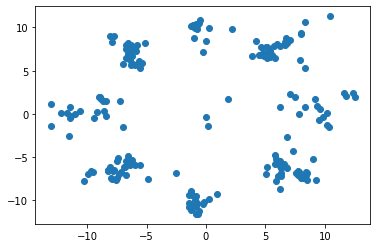

  8%|▊         | 401/5000 [00:42<09:55,  7.73it/s]

Current lr:  0.07290000000000002
On batch number 400 ELBO is -10.879351615905762
On batch number 400 Best ELBO is -8.362927436828613


 10%|█         | 500/5000 [00:53<07:53,  9.50it/s]

On batch number 500 and on k = 1 we have for 0: 0.0 and for +1: 1.0
Step size for 0-th transition is 0.8581435084342957
Alpha (ref) for 0-th transition is 0.4489646553993225
On batch number 500 and on k = 2 we have for 0: 0.505 and for +1: 0.495
Step size for 1-th transition is 0.09617368876934052
Alpha (ref) for 1-th transition is 0.8556273579597473
On batch number 500 and on k = 3 we have for 0: 0.445 and for +1: 0.555
Step size for 2-th transition is 1.463721513748169
Alpha (ref) for 2-th transition is 0.19407767057418823
On batch number 500 and on k = 4 we have for 0: 0.51 and for +1: 0.49
Step size for 3-th transition is 0.14256404340267181
Alpha (ref) for 3-th transition is 0.656525731086731
On batch number 500 and on k = 5 we have for 0: 0.505 and for +1: 0.495
Step size for 4-th transition is 0.08164379745721817
Alpha (ref) for 4-th transition is 0.7676033973693848


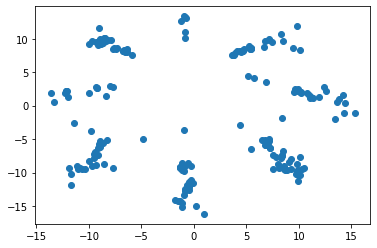

 10%|█         | 501/5000 [00:53<09:39,  7.77it/s]

Current lr:  0.06561000000000002
On batch number 500 ELBO is -14.151058197021484
On batch number 500 Best ELBO is -8.362927436828613


 11%|█         | 528/5000 [00:56<07:55,  9.40it/s]

Early stopping on 528


In [11]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac):
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_r = -args.K * torch_log_2
    log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo

if args.step_conditioning == 'fixed':
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num ) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
            print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha += current_log_alphas
        sum_log_jacobian += log_jac
        
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [12]:
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [13]:
# args.n_steps = args.K # how many samples to use
# args.n_warmup = 0 # num of first samples to refuse

# args.n_chains = 1000 # how many chains to model

# q_init = args.std_normal.sample((args.n_chains, args.z_dim))
# p_init = args.std_normal.sample((args.n_chains, args.z_dim))

In [14]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
    q_new, p_new, _, _, _ = our_kernel[i % args.K].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                   k=cond_vectors[i % args.K])
iterator.close()
    
samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
    q_new, p_new, _, _, a = our_kernel[i % args.K].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                   k=cond_vectors[i % args.K])
    
    samples_our[i] = q_new.detach()
iterator.close()

  0%|          | 5/1000 [00:00<00:22, 43.46it/s]

Now we are running warmup!


  1%|          | 8/1000 [00:00<00:13, 72.03it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:14<00:00, 69.15it/s]


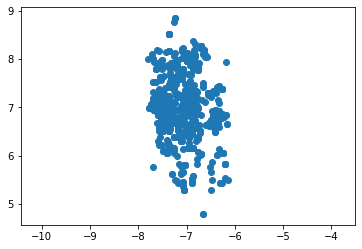

In [24]:
chain_num = 9
plt.scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu())
plt.axis('equal');